**Helpful Links: Where the Data Lives**

Open Academic Society: [Project Page](https://www.openacademic.ai/oag/)

Microsoft Research: [MS Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/)

In [1]:
import pandas as pd

In [2]:
data = pd.read_json('data/mag_papers_0/mag_subset.txt', lines=True)

In [3]:
data.shape

(10000, 19)

In [4]:
data.columns

Index(['abstract', 'authors', 'doc_type', 'doi', 'fos', 'id', 'issue',
       'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'publisher',
       'references', 'title', 'url', 'venue', 'volume', 'year'],
      dtype='object')

In [5]:
# filter out non-English articles

model_df = data[data.lang == 'en']

model_df.shape

(5167, 19)

In [6]:
# keep abstract, authors, fos, keywords, year, title
model_df = model_df.drop(['doc_type', 'doi', 'id', 'issue', 'lang', 'n_citation', 'page_end', 
                            'page_start', 'publisher', 'references', 'url', 'venue', 'volume'], axis=1)

model_df.shape

(5167, 6)

# (1) raw data > algorithm w/ XKCD comic

## Content Based Recommendation using Jaccard Similarity

How to go about building a recommender system? 

Let's start simple with a few fields. We'll calculate the Jaccard Similarity between two items, then rank the results to choose a "most similar" paper for each input.

In [7]:
model_df.head(2)

,abstract,authors,fos,keywords,title,year
0,A system and method for maskless direct write ...,NaN,"[Electronic engineering, Computer hardware, En...",NaN,System and Method for Maskless Direct Write Li...,2015
1,NaN,[{'name': 'Ahmed M. Alluwaimi'}],"[Biology, Virology, Immunology, Microbiology]","[paratuberculosis, of, subspecies, proceedings...",The dilemma of the Mycobacterium avium subspec...,2016


We can already see that this dataset will need some wrangling. Lists and dictionaries are good for data storage, but not [tidy](http://vita.had.co.nz/papers/tidy-data.html) or well-suited for machine learning without some unpacking.

In [8]:
unique_fos = sorted(list({ feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

unique_year = sorted(model_df['year'].astype('str').unique())

paper_features = unique_fos + unique_year

In [9]:
def feature_array(x, var, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({var + '_' + unique_array[j]: 1})
                else:
                    var_dict.update({var + '_' + unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({var + '_' + unique_array[j]: 1})
                else:
                    var_dict.update({var + '_' + unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, dtype='str').T
    
    return feature_df

We will start with a simple example of building a recommender with just a few fields, building sparse arrays of available features to calculate for the Jaccard similary between papers. We will see if reasonably similar papers can be found in a timely manner.

In [10]:
%time fos_features = feature_array(model_df['fos'], 'fos', unique_fos)

from sys import getsizeof
print('Size of fos feature array: ', getsizeof(fos_features))

CPU times: user 9min 10s, sys: 4.99 s, total: 9min 15s
Wall time: 9min 23s
Size of fos feature array:  779231832


In [11]:
%time year_features = feature_array(model_df['year'], 'year', unique_year)

print('Size of year feature array: ', getsizeof(year_features))

CPU times: user 16 s, sys: 80.3 ms, total: 16.1 s
Wall time: 16.3 s
Size of year feature array:  22714156


In [12]:
year_features.shape[1] + fos_features.shape[1]

4849

In [13]:
# now looking at 5167 x  4849 array for our feature space

%time first_features = fos_features.join(year_features).T

print('Size of first feature array: ', getsizeof(first_features))

CPU times: user 3.57 s, sys: 369 ms, total: 3.94 s
Wall time: 3.95 s
Size of first feature array:  802239497


Not bad, but waiting 8+ mins for 10K observations for one feature seems a little slow. We are also using 802+MB with only two variables from our original data set. 

Let's see how our current features perform at giving us a good recommendation. We'll define a "good" recommendation as a paper that looks similar to the input.

In [14]:
first_features.head()

,0,1,2,5,7,8,9,10,11,12,...,9979,9980,9981,9984,9986,9988,9994,9997,9998,9999
fos_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fos_1/N expansion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fos_10G-PON,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fos_3D radar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fos_3D single-object recognition,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from scipy.spatial.distance import cosine

def item_collab_filter(features_df):
    item_similarities = pd.DataFrame(index = features_df.columns, columns = features_df.columns)
    
    for i in features_df.columns:
        for j in features_df.columns:
            item_similarities.loc[i][j] = 1 - cosine(features_df[i], features_df[j])
    
    return item_similarities

In [16]:
%time foo1 = item_collab_filter(first_features.loc[:, 0:10])

CPU times: user 81.2 ms, sys: 1.88 ms, total: 83.1 ms
Wall time: 83.9 ms


In [17]:
%time foo2 = item_collab_filter(first_features.loc[:, 0:1000])

CPU times: user 4min 27s, sys: 1.78 s, total: 4min 29s
Wall time: 4min 30s


In [20]:
first_features.shape

(4849, 5167)

In [21]:
%time foo3 = item_collab_filter(first_features.loc[:, 0:2500])

CPU times: user 27min 17s, sys: 12.4 s, total: 27min 29s
Wall time: 27min 54s


In [23]:
# remove this for the book. it's just for testing out different sizes of observations x features
foo = foo

**[TODO]** Why is this slow? We are taking the dot product of 4849 x 1000 matrix using a nested for loop. While the 4849 x 10 took ms, we increase the time per loop as we increase the # of observations we add to the model. Remember, this is a subset of the total available dataset, filtered for English only papers. As we move closer to a "good" result, we would need to go back and test on the larger set for our best results. 

We need to get a better idea of how these features will translate to us getting a good recommendation. Do we have enough observations to move forward? Let's plot a heatmap to see if we have any papers that are similar to each other.

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<IPython.core.display.Javascript object>


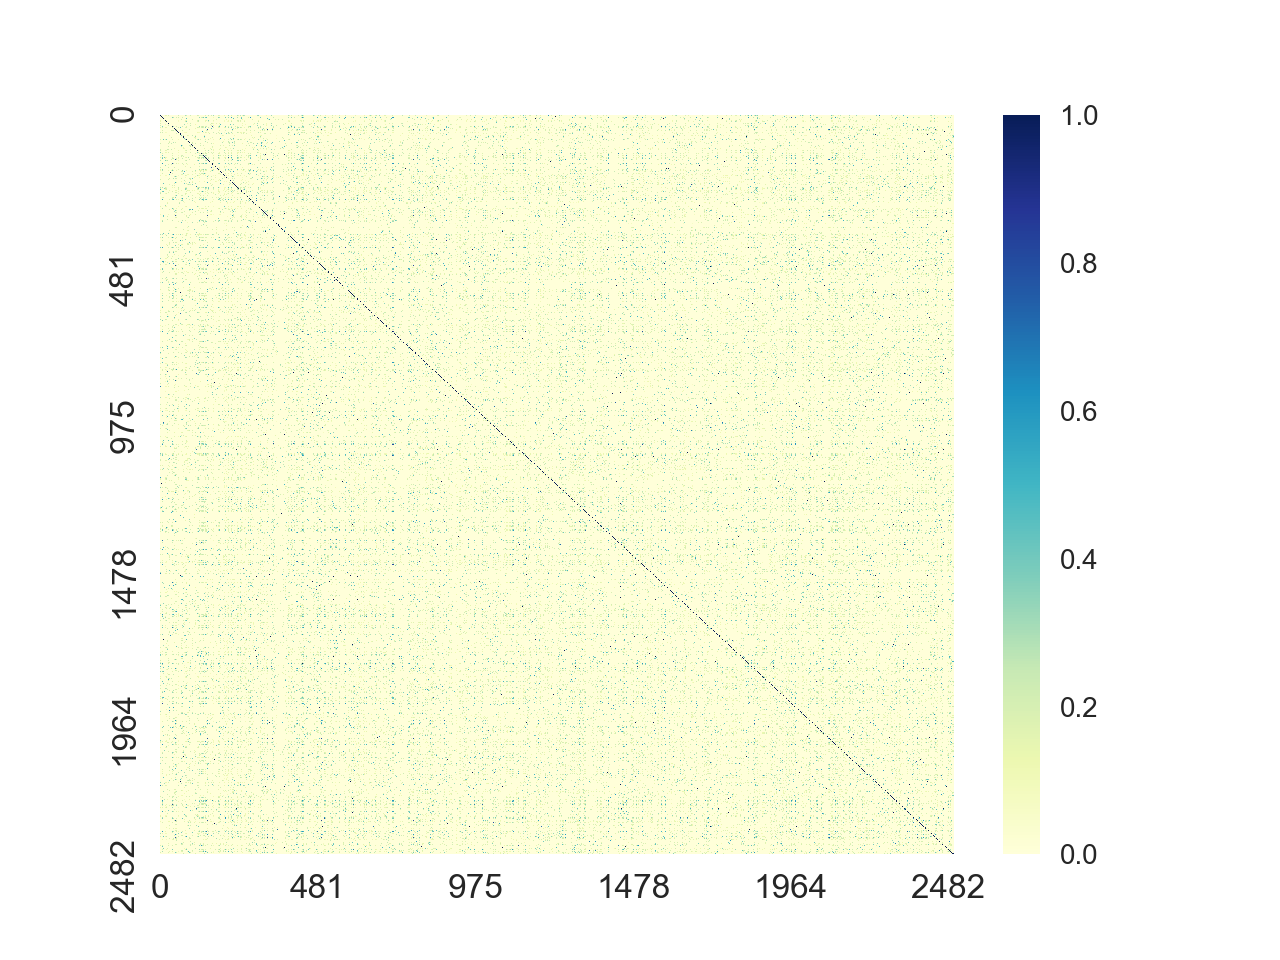

In [63]:
%matplotlib notebook
sns.set()
ax = sns.heatmap(foo.fillna(0), 
                 vmin=0, vmax=1, 
                 cmap="YlGnBu", 
                 xticklabels=250, yticklabels=250)
ax.tick_params(labelsize=12)

That looks promising. While we have a lot of empty space, which shows that our data set is fairly diverse, we can see that our cosine measure is accurately predicting that each paper is most similar to itself. We also have some other high score candidates. These may or may not be good recommendations qualitatively, but at least we can see that our methods are not so mad.

In [43]:
def paper_recommender(paper_index):
    print('Based on the paper: \nindex = ', paper_index)
    print(model_df.iloc[paper_index])
    top_results = foo.loc[paper_index].sort_values(ascending=False).head(4)
    print('\nTop three results: ') 
    order = 1
    for i in top_results.index.tolist()[-3:]:
        print(order,'. Paper index = ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1

In [44]:
paper_recommender(2)

Based on the paper: 
index =  2
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object

Top three results: 
1 . Paper index =  1817
Similarity score:  1.0
abstract    Gas chromatography–mass spectrometry (GC-MS) i...
authors     [{'name': 'Silas G. Villas-Boas'}, {'name': 'K...
fos         [Chromatography, Chemistry, Analytical chemist...
keywords    [health research, uk clinical guidelines, biol...
title       Alkylation or Silylation for Analysis of Amino...
year                                                     2011
Name: 3563, dtype: object 

2 . Paper index =  2
Similarity score:  1.0
abstract                                                  NaN

Yikes. That's not that great. Can we just push more data through? Well, yes, if you don't need speedy results. 

Even on this small data set, the time for training our model is too slow for quick, iterative engineering. 

Let's try some of our new feature engineering tricks to see if we can speed up computation time and find better features.

# (2) a few features, pipe, outcome

In [45]:
# first, let's start a new dataframe for our new features

new_df = pd.DataFrame(index = model_df.index)

Okay, we remember than numerical features unevenly distributed across a dataset can unnecessarily increase the size of our feature space. Let's wrangle this in first.

In [46]:
model_df['year'].tail()

9988    2012
9994    2007
9997    2008
9998    2001
9999    2015
Name: year, dtype: int64

In [47]:
print("Year spread: ", model_df['year'].min()," - ", model_df['year'].max())
print("Quantile spread:\n", model_df['year'].quantile([0.25, 0.5, 0.75]))

Year spread:  1831  -  2017
Quantile spread:
 0.25    1990.0
0.50    2005.0
0.75    2012.0
Name: year, dtype: float64


<IPython.core.display.Javascript object>


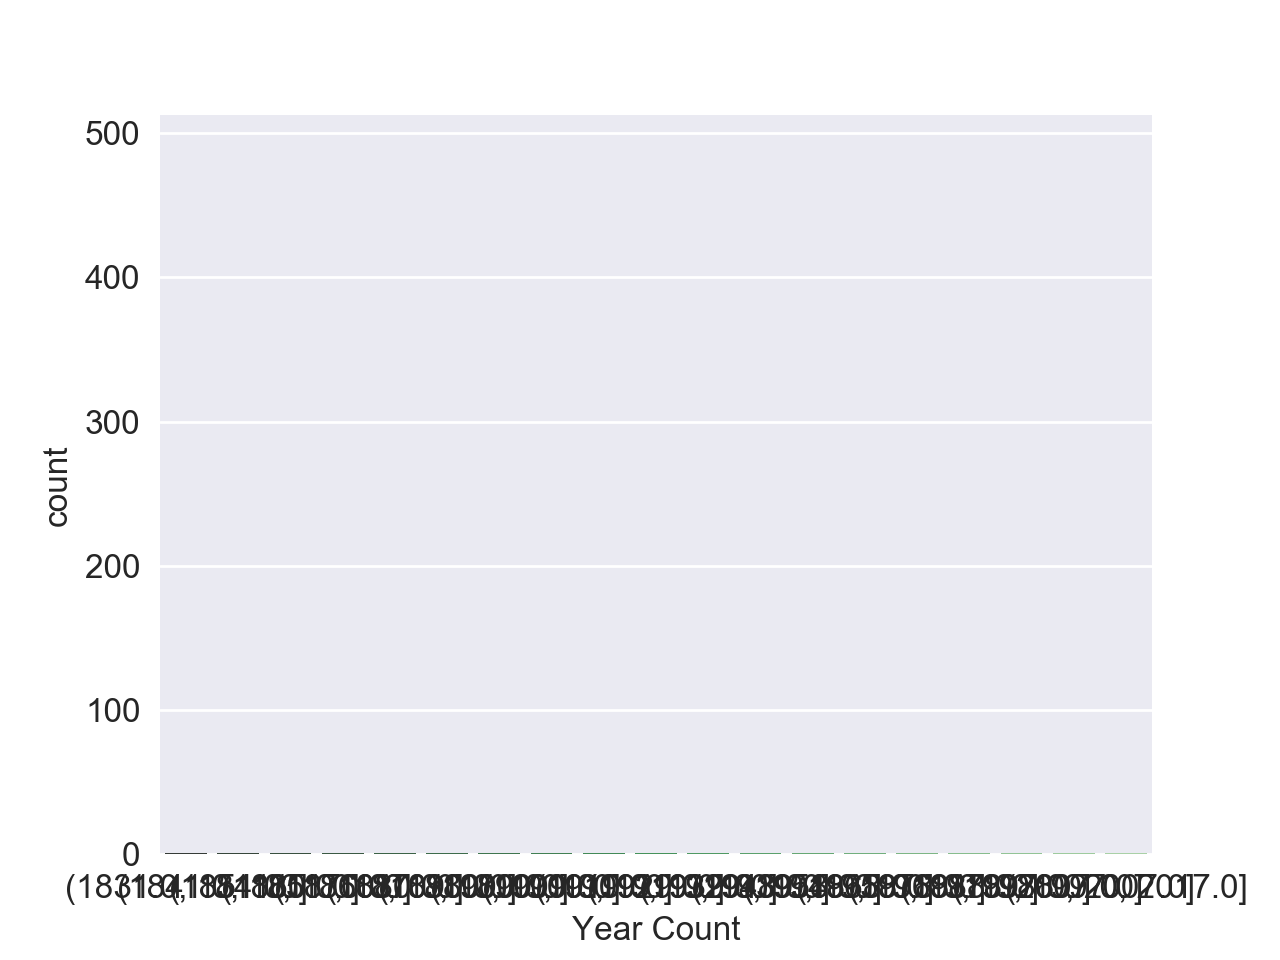

Text(0,0.5,'Occurrence')

In [64]:
# plot years to see the distribution
fig, ax = plt.subplots()
model_df['year'].hist(ax=ax, bins=100)
ax.tick_params(labelsize=12)
ax.set_xlabel('Year Count', fontsize=12)
ax.set_ylabel('Occurrence', fontsize=12)

We can see from the uneven distribution that this is an excellent candidate for binning and dummy coding. Lucky for us, pandas can do all these things using built-in functions. Our results will be easy to interpret.

## years: binning + One-Hot Encoding

In [49]:
model_df['year'].max() - model_df['year'].min()

186

In [50]:
# insert binning here (by 10 years)
bins = int(round((model_df['year'].max() - model_df['year'].min()) / 10))

temp_df = pd.DataFrame(index = model_df.index)
temp_df['yearBinned'] = pd.cut(model_df['year'].tolist(), bins, precision = 0)

In [51]:
# now we only have as many bins as we created(grouping together by 10 years)
print('We have reduced from', len(model_df['year'].unique()),
      'to', len(temp_df['yearBinned'].values.unique()), 'features representing the year.')

We have reduced from 137 to 19 features representing the year.


In [52]:
new_df = pd.get_dummies(temp_df['yearBinned'])
new_df.head()

,"(1831.0, 1841.0]","(1841.0, 1851.0]","(1851.0, 1860.0]","(1860.0, 1870.0]","(1870.0, 1880.0]","(1880.0, 1890.0]","(1890.0, 1900.0]","(1900.0, 1909.0]","(1909.0, 1919.0]","(1919.0, 1929.0]","(1929.0, 1939.0]","(1939.0, 1948.0]","(1948.0, 1958.0]","(1958.0, 1968.0]","(1968.0, 1978.0]","(1978.0, 1988.0]","(1988.0, 1997.0]","(1997.0, 2007.0]","(2007.0, 2017.0]"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [93]:
new_df.columns.categories

IntervalIndex([(1831.0, 1841.0], (1841.0, 1851.0], (1851.0, 1860.0], (1860.0, 1870.0], (1870.0, 1880.0] ... (1968.0, 1978.0], (1978.0, 1988.0], (1988.0, 1997.0], (1997.0, 2007.0], (2007.0, 2017.0]]
              closed='right',
              dtype='interval[float64]')

<IPython.core.display.Javascript object>


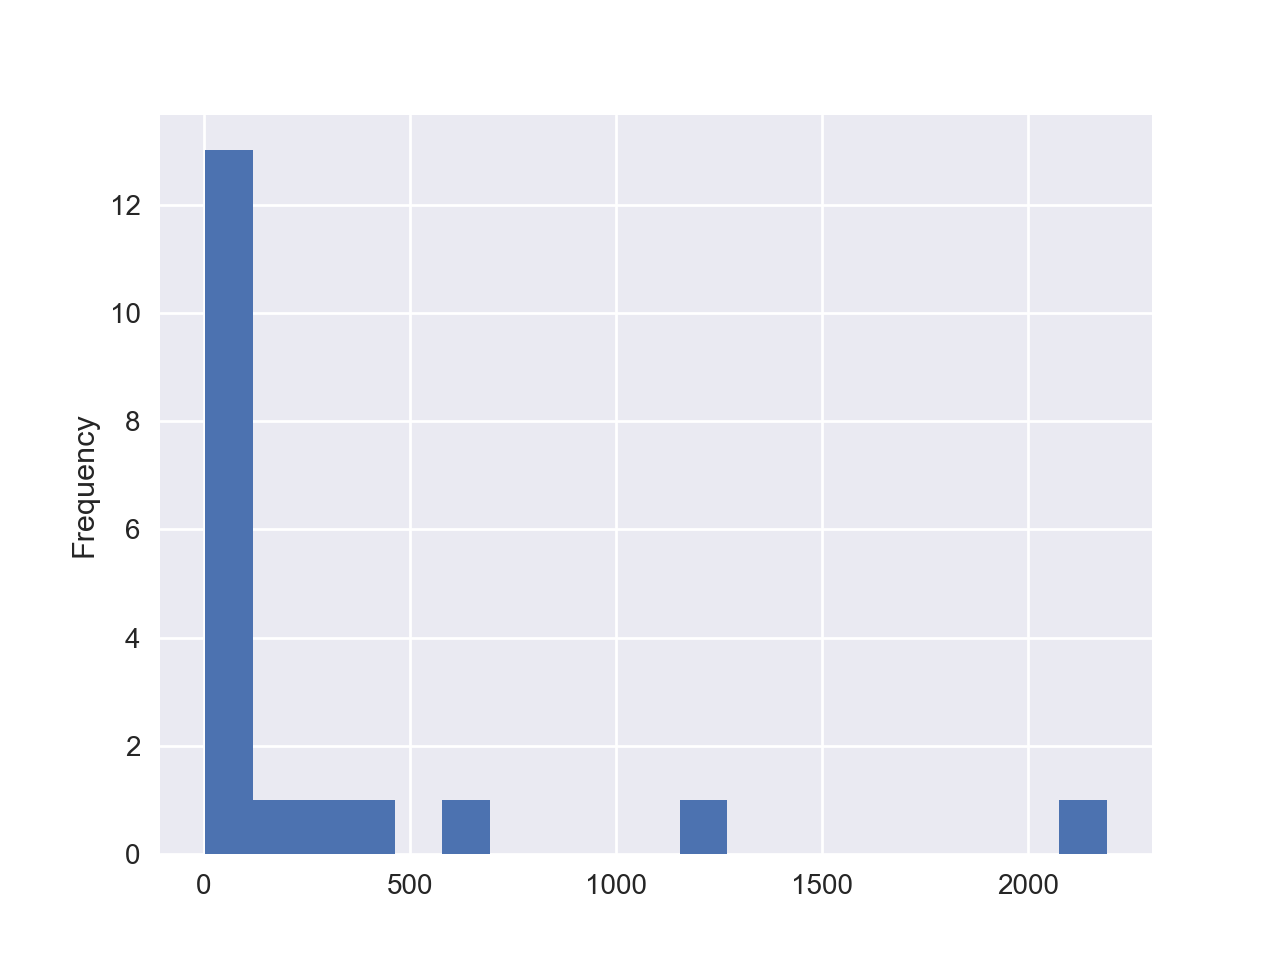

In [112]:
####### TODO > Fix this plot!!! ######
######################################
# let's look at the new distribution
%matplotlib notebook
#ax = sns.countplot(x=new_df.sum(axis=1), data=new_df)
new_df.sum().plot.hist(bins = 19)

## TODO >> fields of study: Feature Hashing?

NOTE: I don't know that Feature Hashing is the best method here. I'm really looking for reduction in features. Maybe some clustering or binning?

In [347]:
# need to fill in "NaN" for sklearn
fos_df = model_df.fillna('None')

In [348]:
fos_df['fos'].head()

0    [Electronic engineering, Computer hardware, En...
1        [Biology, Virology, Immunology, Microbiology]
2                                                 None
5                                                 None
7           [Medicine, Pathology, Gynecology, Surgery]
Name: fos, dtype: object

Let's leverage work we have already done. We have a sparse array of parsed field of study fields. The names for the feature space take up the most room. We'll pare this down by taking advantage of sklearn's FeatureHasher.

In [356]:
fos_features.head(2)

,fos_0,fos_1/N expansion,fos_10G-PON,fos_3D radar,fos_3D single-object recognition,fos_3G MIMO,fos_40-bit encryption,fos_56-bit encryption,fos_78xx,fos_ANK1,...,fos_hosts,fos_k-minimum spanning tree,fos_k-nearest neighbors algorithm,fos_m-derived filter,fos_microRNA,fos_pH,fos_photoperiodism,fos_route,fos_string,fos_Ćuk converter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [360]:
m = len(unique_fos)
m

4712

In [377]:
from sklearn.feature_extraction import FeatureHasher

h = FeatureHasher(n_features = m, input_type = "string")
f = h.transform(fos_features)
f.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
# how to use over collaborative filter again when in this shape??

# (3) a few more features, pipe, outcome

## abstract: stopwords, frequency based filtering (tf-idf?)

In [273]:
# need to fill in NaN for sklearn
abstract_df = model_df.fillna('None')

# abstract: stopwords, frequency based filtering (tf-idf?)
abstract_df['abstract'].head()

0    A system and method for maskless direct write ...
1                                                 None
2                                                 None
5                                                 None
7    Full textFull text is available as a scanned c...
Name: abstract, dtype: object

In [275]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_abstract = vectorizer.fit_transform(abstract_df['abstract'])

X_abstract

<5167x33339 sparse matrix of type '<class 'numpy.float64'>'
	with 188959 stored elements in Compressed Sparse Row format>

In [276]:
print("n_samples: %d, n_features: %d" % X_abstract.shape)

n_samples: 5167, n_features: 33339


## authors: One-Hot Encoding using sklearn DictVectorizer()

In [ ]:
authors_df = pd.DataFrame(model_df.authors)
authors_df.head()

In [ ]:
import json

In [ ]:
type(authors_df.authors[5][0])

In [ ]:
authors_list = []

for row in authors_df.itertuples():
    # create a dictionary from each Series index
    if type(row.authors) is list:
        # add these keys + values to our running dictionary    
        y = dict.fromkeys(row.authors[0].values(), row.Index)
        authors_list.append(y)

In [ ]:
authors_list[0:5]

In [ ]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = authors_list
X = v.fit_transform(D)

In [ ]:
X[0:5]

In [ ]:
len(authors_dict)

# (4) a few more...does that help? results? performance?
### no? okay. return to best case. all about experimentation.

## titles: noun phrases + chunking

In [ ]:
model_df['title'].head()

## keywords: stemming?

In [ ]:
model_df['keywords'].head()

## summary ##

As you can see, building models for machine learning is easy. Building *good* models for the useful outcomes takes time and work. We hiked through the messy processes here of examining a collection of possible variables and experimenting with different feature engineering methods to achieve better results. We define better here as not just good outcomes from our training and testing, but also reducing the size of the model and time it takes us to iterate over different experiments.

**Citations**

Jie Tang, Jing Zhang, Limin Yao, Juanzi Li, Li Zhang, and Zhong Su. ArnetMiner: Extraction and Mining of Academic Social Networks. In Proceedings of the Fourteenth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (SIGKDD’2008). pp.990-998. [PDF](http://keg.cs.tsinghua.edu.cn/jietang/publications/KDD08-Tang-et-al-ArnetMiner.pdf) [Slides](http://keg.cs.tsinghua.edu.cn/jietang/publications/KDD08-Tang-et-al-Arnetminer.ppt) [System](http://aminer.org/) [API](http://aminer.org/RESTful_service)

Arnab Sinha, Zhihong Shen, Yang Song, Hao Ma, Darrin Eide, Bo-June (Paul) Hsu, and Kuansan Wang. 2015. An Overview of Microsoft Academic Service (MAS) and Applications. In Proceedings of the 24th International Conference on World Wide Web (WWW ’15 Companion). ACM, New York, NY, USA, 243-246. [PDF](https://www.microsoft.com/en-us/research/publication/an-overview-of-microsoft-academic-service-mas-and-applications-2/) [System](https://academic.microsoft.com/) [API](https://docs.microsoft.com/en-us/azure/cognitive-services/academic-knowledge/home)